In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [207]:
train_data_path = "registros_entrenamiento-2.csv"
eval_data_path = "registros_evaluacion-2.csv"

**Paso 1: Análisis Exploratorio de Datos (EDA)**

In [208]:
train_df = pd.read_csv(train_data_path)

In [ ]:
display(train_df.head())
display(train_df.info)
display(train_df.describe)

,IdPasajero,PlanetaOrigen,SuenoCriogenico,Cabina,Destino,Edad,ServicioVIP,ServicioHabitacion,Cafeteria,CentroComercial,Spa,CubiertaVR,Transportado,Iniciales
0,004D8BSQ,NaN,False,C/268/S,TRAPPIST-1e,27.0,False,0.0,63.0,8.0,129.0,2960.0,False,YUW
1,009TL1XF,Europa,False,C/258/P,55 Cancri e,18.0,False,0.0,3492.0,0.0,506.0,8.0,True,SFW
2,00A9QC49,Europa,False,A/30/S,TRAPPIST-1e,44.0,True,1409.0,910.0,17.0,1452.0,3782.0,False,POY
3,00BJM5YI,Earth,False,E/24/P,TRAPPIST-1e,48.0,False,0.0,111.0,0.0,1508.0,0.0,False,ZIT
4,00DQRZAR,Mars,False,F/1550/P,TRAPPIST-1e,68.0,True,523.0,0.0,859.0,201.0,782.0,False,TJJ


<bound method DataFrame.info of      IdPasajero PlanetaOrigen SuenoCriogenico    Cabina        Destino  Edad  \
0      004D8BSQ           NaN           False   C/268/S    TRAPPIST-1e  27.0   
1      009TL1XF        Europa           False   C/258/P    55 Cancri e  18.0   
2      00A9QC49        Europa           False    A/30/S    TRAPPIST-1e  44.0   
3      00BJM5YI         Earth           False    E/24/P    TRAPPIST-1e  48.0   
4      00DQRZAR          Mars           False  F/1550/P    TRAPPIST-1e  68.0   
...         ...           ...             ...       ...            ...   ...   
7995   ZZCM7TR2          Mars           False   E/558/P    TRAPPIST-1e  36.0   
7996   ZZIMSTE2         Earth             NaN   F/946/S    TRAPPIST-1e  16.0   
7997   ZZKIIBBP         Earth            True    G/89/P  PSO J318.5-22  20.0   
7998   ZZLMOPKH        Europa           False    A/54/P    55 Cancri e  46.0   
7999   ZZLSM7SN         Earth            True   G/284/S    TRAPPIST-1e  24.0   

     Se

<bound method NDFrame.describe of      IdPasajero PlanetaOrigen SuenoCriogenico    Cabina        Destino  Edad  \
0      004D8BSQ           NaN           False   C/268/S    TRAPPIST-1e  27.0   
1      009TL1XF        Europa           False   C/258/P    55 Cancri e  18.0   
2      00A9QC49        Europa           False    A/30/S    TRAPPIST-1e  44.0   
3      00BJM5YI         Earth           False    E/24/P    TRAPPIST-1e  48.0   
4      00DQRZAR          Mars           False  F/1550/P    TRAPPIST-1e  68.0   
...         ...           ...             ...       ...            ...   ...   
7995   ZZCM7TR2          Mars           False   E/558/P    TRAPPIST-1e  36.0   
7996   ZZIMSTE2         Earth             NaN   F/946/S    TRAPPIST-1e  16.0   
7997   ZZKIIBBP         Earth            True    G/89/P  PSO J318.5-22  20.0   
7998   ZZLMOPKH        Europa           False    A/54/P    55 Cancri e  46.0   
7999   ZZLSM7SN         Earth            True   G/284/S    TRAPPIST-1e  24.0   

     

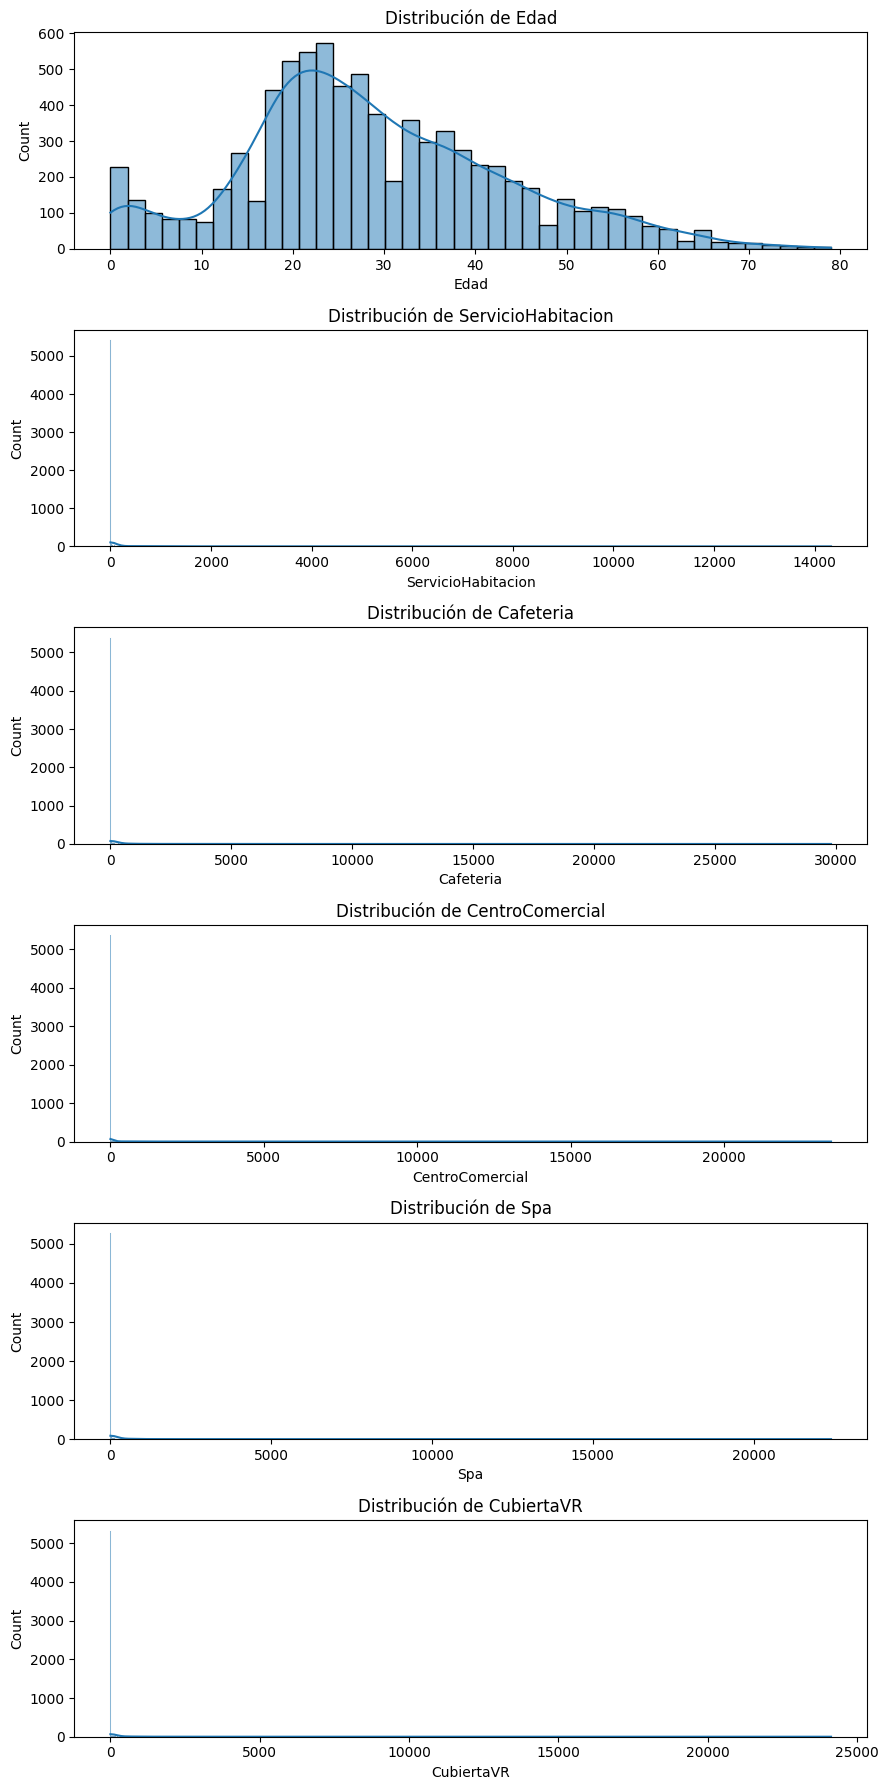

In [4]:
# Histogramas y KDE de variables numéricas clave
num_cols = train_df.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(9, len(num_cols)*3))
for ax, col in zip(axes, num_cols):
    sns.histplot(train_df[col], kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

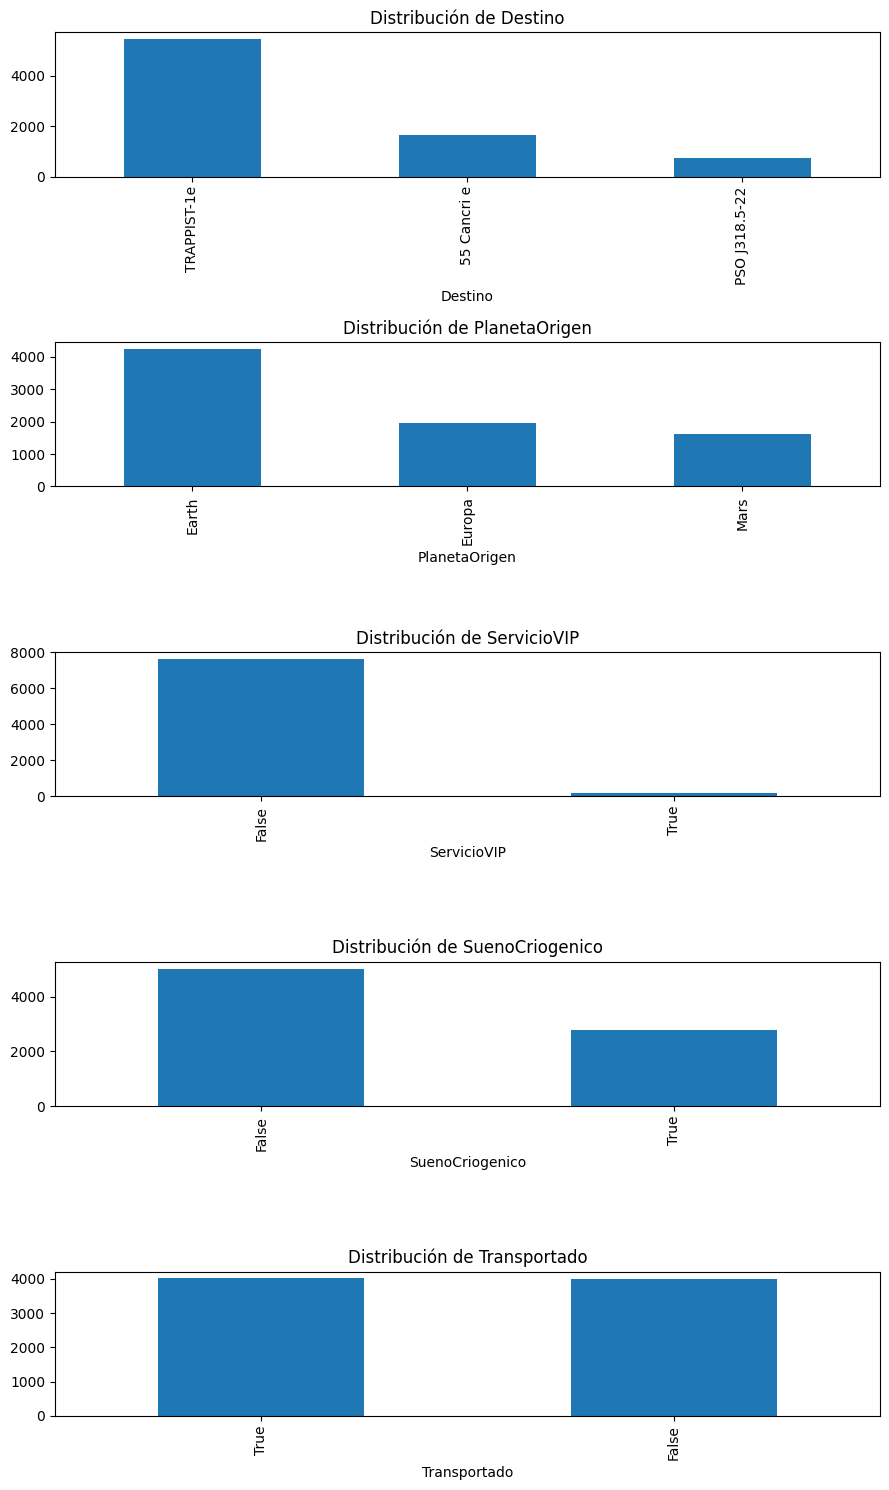

In [39]:
ignore_cols = ["IdPasajero", "Cabina", "Iniciales"]

# Histogramas y KDE de variables numéricas clave
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.difference(ignore_cols).union(['Transportado'])

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(9, len(cat_cols)*3))
for ax, col in zip(axes, cat_cols):
    conteo = train_df[col].value_counts()
    conteo.plot(kind='bar', ax=ax)
    ax.set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()


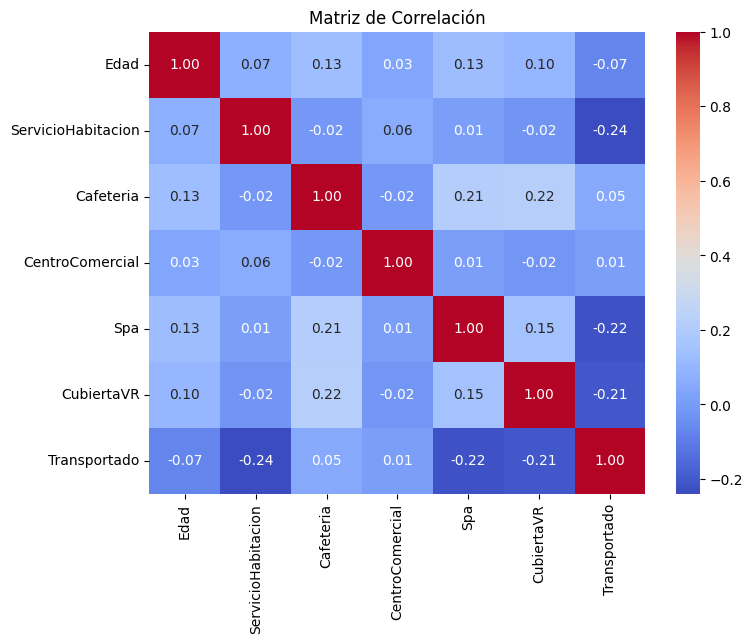

Transportado          1.000000
Cafeteria             0.051358
CentroComercial       0.010145
Edad                 -0.073805
CubiertaVR           -0.205830
Spa                  -0.222618
ServicioHabitacion   -0.238996
Name: Transportado, dtype: float64

In [ ]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

corr['Transportado'].sort_values(ascending=False)

No parece haber una relación significante entre ningúna de las variables numéricas y la variable 'Transportado'

**Paso 2: Limpieza de Datos e Ingeniería de Características**

In [209]:
faltantes = train_df.isnull().sum().sort_values(ascending=False)
porcentaje = (train_df.isnull().mean()*100).sort_values(ascending=False) # Computes the mean of each column, treating True as 1 and False as 0,
missing_df = pd.DataFrame({'Valores Faltantes': faltantes, '% Faltante': porcentaje.round(2)})
missing_df

,Valores Faltantes,% Faltante
SuenoCriogenico,197,2.46
CentroComercial,191,2.39
ServicioVIP,188,2.35
Cabina,179,2.24
PlanetaOrigen,177,2.21
CubiertaVR,174,2.17
Spa,173,2.16
Edad,165,2.06
Destino,163,2.04
ServicioHabitacion,161,2.01


In [210]:
# Seleccionar columnas numéricas
num_col = train_df.select_dtypes(include=['number']).columns

# Imputación de valores faltantes con la mediana para cada columna numérica
for col in num_col:
    if train_df[col].isnull().any():
        mediana = train_df[col].median()
        train_df[col] = train_df[col].fillna(mediana)
        print(f"Imputados valores faltantes en '{col}' con la mediana = {mediana}")
    else:
        print(f"No se encontraron valores faltantes en '{col}'.")

# Verificación rápida
print("\nValores faltantes restantes en todo el DataFrame:", train_df.isnull().sum().sum())

Imputados valores faltantes en 'Edad' con la mediana = 27.0
Imputados valores faltantes en 'ServicioHabitacion' con la mediana = 0.0
Imputados valores faltantes en 'Cafeteria' con la mediana = 0.0
Imputados valores faltantes en 'CentroComercial' con la mediana = 0.0
Imputados valores faltantes en 'Spa' con la mediana = 0.0
Imputados valores faltantes en 'CubiertaVR' con la mediana = 0.0

Valores faltantes restantes en todo el DataFrame: 904


In [211]:
# Identificar columnas categóricas
cat_col = train_df.select_dtypes(include=['object', 'category']).columns.union(['Transportado'])

# Eliminar filas con valores faltantes en cualquier columna categórica
before = len(train_df)
train_df = train_df.dropna(subset=cat_col)
after = len(train_df)

print(f"Filas eliminadas por valores faltantes en columnas categóricas: {before - after}")
# Verificación rápida
print("\nValores faltantes restantes en todo el DataFrame:", train_df.isnull().sum().sum())

Filas eliminadas por valores faltantes en columnas categóricas: 864

Valores faltantes restantes en todo el DataFrame: 0


In [212]:
train_df[['CubiertaCabina', 'NumCabina', 'LadoCabina']] = train_df['Cabina'].str.split('/', expand=True)
train_df = train_df.drop(columns=['IdPasajero', 'Iniciales', 'Cabina'])
train_df.NumCabina = train_df.NumCabina.astype(int)

In [213]:
cat_col = train_df.select_dtypes(include=['object', 'category']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
encoded = encoder.fit_transform(train_df[cat_col])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(train_df[cat_col].columns),
    index=train_df.index
)

encoded_df.head()

,PlanetaOrigen_Earth,PlanetaOrigen_Europa,PlanetaOrigen_Mars,SuenoCriogenico_True,Destino_55 Cancri e,Destino_PSO J318.5-22,Destino_TRAPPIST-1e,ServicioVIP_True,CubiertaCabina_A,CubiertaCabina_B,CubiertaCabina_C,CubiertaCabina_D,CubiertaCabina_E,CubiertaCabina_F,CubiertaCabina_G,CubiertaCabina_T,LadoCabina_S
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [214]:
num_col = train_df.select_dtypes(include=['number']).columns.union(["NumCabina"])
scaler = StandardScaler()
scaled = scaler.fit_transform(train_df[num_col])

scaled_df = pd.DataFrame(scaled, columns=num_col, index=train_df.index)
scaled_df.head()

,Cafeteria,CentroComercial,CubiertaVR,Edad,NumCabina,ServicioHabitacion,Spa
1,1.855688,-0.283175,-0.256958,-0.753424,-0.665209,-0.343660,0.170020
2,0.275622,-0.255236,3.019962,1.051191,-1.109802,1.904125,1.000341
3,-0.213329,-0.283175,-0.263904,1.328824,-1.121502,-0.343660,1.049493
4,-0.281256,1.128554,0.415097,2.716988,1.854154,0.490685,-0.097684
5,-0.278808,-0.131977,-0.263904,1.537048,-0.825107,0.962895,-0.240752


In [215]:
final_train_df = pd.concat([scaled_df, encoded_df], axis=1)
final_train_df.head()

,Cafeteria,CentroComercial,CubiertaVR,Edad,NumCabina,ServicioHabitacion,Spa,PlanetaOrigen_Earth,PlanetaOrigen_Europa,PlanetaOrigen_Mars,...,ServicioVIP_True,CubiertaCabina_A,CubiertaCabina_B,CubiertaCabina_C,CubiertaCabina_D,CubiertaCabina_E,CubiertaCabina_F,CubiertaCabina_G,CubiertaCabina_T,LadoCabina_S
1,1.855688,-0.283175,-0.256958,-0.753424,-0.665209,-0.343660,0.170020,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.275622,-0.255236,3.019962,1.051191,-1.109802,1.904125,1.000341,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.213329,-0.283175,-0.263904,1.328824,-1.121502,-0.343660,1.049493,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.281256,1.128554,0.415097,2.716988,1.854154,0.490685,-0.097684,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,-0.278808,-0.131977,-0.263904,1.537048,-0.825107,0.962895,-0.240752,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Paso 4: Entrenamiento y Evaluación del Modelo**

Se hicieron pruebas con los modelos XGBoost, Random Forest y Logistic Regression. XGBoost tuvo un mejor desempeño porque puede capturar relaciones no lineales y complejas entre las variables. A diferencia de la regresión logística, no asume linealidad, y frente a Random Forest, su enfoque de *boosting* ajusta los errores de forma secuencial, usando regularización y optimización más eficiente. Esto le permite lograr un mejor equilibrio entre sesgo y varianza.


In [216]:
x = final_train_df
y = train_df["Transportado"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Accuracy: 0.8123249299719888


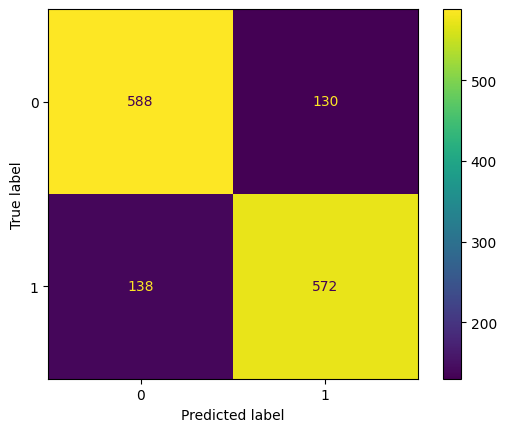

In [225]:
xgboost_ = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'  # avoids warning
)

xgboost_.fit(x_train, y_train)
y_pred = xgboost_.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Si quieres visualizarla gráficamente:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


El modelo tiene un desempeño bueno, con una precisión general del 81%. Esto indica que logra predecir correctamente la mayoría de los casos de pasajeros transportados y no transportados.

Se equivoca ligeramente más en el segmento de falsos negativos ya que tiene 138 frente a 130 falsos positivos.
Esto significa que, con más frecuencia, predice que un pasajero no fue transportado cuando en realidad sí lo fue.

**Paso 5: Generación del Archivo de Entrega**

In [221]:
def full_preprocess(df, ids):
    # imputar valores numéricos faltantes
    num_col = df.select_dtypes(include=['number']).columns

    for col in num_col:
        if df[col].isnull().any():
            mediana = df[col].median()
            df[col] = df[col].fillna(mediana)
            print(f"Imputados valores faltantes en '{col}' con la mediana = {mediana}")
        else:
            print(f"No se encontraron valores faltantes en '{col}'.")
            
    print("\nValores faltantes restantes en todo el DataFrame:", df.isnull().sum().sum())

    # eliminar valores categóricos faltantes
    cat_col = df.select_dtypes(include=['object', 'category']).columns

    before = len(df)
    df = df.dropna(subset=cat_col)
    after = len(df)

    print(f"Filas eliminadas por valores faltantes en columnas categóricas: {before - after}")
    print("\nValores faltantes restantes en todo el DataFrame:", df.isnull().sum().sum())

    # separar la cabina en 3 partes
    df[['CubiertaCabina', 'NumCabina', 'LadoCabina']] = df['Cabina'].str.split('/', expand=True)
    df.NumCabina = train_df.NumCabina.astype(int)

    ids.append(df.IdPasajero)

    # eliminar columnas irrelevantes
    df = df.drop(columns=['IdPasajero', 'Iniciales', 'Cabina'])

    # aplicar one hot encoding
    cat_col = df.select_dtypes(include=['object', 'category']).columns
    encoded = encoder.transform(df[cat_col])

    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(df[cat_col].columns),
        index=df.index
    )

    # escalar datos numéricos 
    num_col = df.select_dtypes(include=['number']).columns.union(['NumCabina'])
    scaled = scaler.transform(df[num_col])

    scaled_df = pd.DataFrame(scaled, columns=num_col, index=df.index)

    # concatenar datos numéricos y categóricos
    return pd.concat([scaled_df, encoded_df], axis=1)

In [226]:
eval_df = pd.read_csv(eval_data_path)

ids = []
final_eval_df = full_preprocess(eval_df, ids)
y_pred = xgboost_.predict(final_eval_df)

Imputados valores faltantes en 'Edad' con la mediana = 26.0
Imputados valores faltantes en 'ServicioHabitacion' con la mediana = 0.0
Imputados valores faltantes en 'Cafeteria' con la mediana = 0.0
Imputados valores faltantes en 'CentroComercial' con la mediana = 0.0
Imputados valores faltantes en 'Spa' con la mediana = 0.0
Imputados valores faltantes en 'CubiertaVR' con la mediana = 0.0

Valores faltantes restantes en todo el DataFrame: 98
Filas eliminadas por valores faltantes en columnas categóricas: 93

Valores faltantes restantes en todo el DataFrame: 0


C:\Users\mauro\AppData\Local\Temp\ipykernel_13584\2655247997.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['CubiertaCabina', 'NumCabina', 'LadoCabina']] = df['Cabina'].str.split('/', expand=True)
C:\Users\mauro\AppData\Local\Temp\ipykernel_13584\2655247997.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['CubiertaCabina', 'NumCabina', 'LadoCabina']] = df['Cabina'].str.split('/', expand=True)
C:\Users\mauro\AppData\Local\Temp\ipykernel_13584\2655247997.py:26: SettingWithCopyWarning: 
A val

In [227]:
out = pd.DataFrame(ids[0], columns=["IdPasajero"])
out['Transportado'] = y_pred

out.to_csv("out.csv", index=False)